Mounting from colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

###Data Prepration

**In this cell:**
1.   Importing necessary libraries
2.   create path variables

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# for showing images in the cell outputs (Jupyter Notebooks / Google Colab)
from tensorflow.keras import regularizers
from IPython.display import display
from ipywidgets import Image
from keras.regularizers import l2, l1
from keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.model_selection import train_test_split

BASE_DIR = '/content/drive/Shareddrives/DeepLearningProject/Coccomini_Gholami_Zara/'
DATA_DIR = BASE_DIR + 'data/numpy data/'
MODEL_DIR = BASE_DIR + 'models/'
PUBLIC_TEST_TENSOR = DATA_DIR + 'public_test_tensor.npy'
PUBLIC_TEST_LABELS = DATA_DIR + 'public_test_labels.npy'
PRIVATE_TEST_TENSOR = DATA_DIR + 'private_test_tensor.npy'

TRAIN_LABELS = DATA_DIR + 'train_labels.npy'
TRAIN_TENSOR = DATA_DIR + 'train_tensor.npy'

Loading data from the direcotories

In [ ]:
train_data = np.load(TRAIN_TENSOR).reshape((5352, 150, 150, 1)) #laoding training data
train_labels = np.load(TRAIN_LABELS)#loading training labels
test_data = np.load(PUBLIC_TEST_TENSOR).reshape((672, 150, 150, 1))#loading test data
test_labels = np.load(PUBLIC_TEST_LABELS)#loading test labels
private_test_data = np.load(PRIVATE_TEST_TENSOR) # loading private test

print("Training Data: ", train_data.shape)
print("Training Labels: ", train_data.shape)
print("Test Data: ", test_data.shape)
print("Test Labels: ", test_labels.shape)
print("Private Test: ", test_labels.shape)
print(np.min(train_data))

EPOCH = 30
BATCH_SIZE = 16
EARLY_STOP_PATIENCE = 4
RESCALE = 65535

Training Data:  (5352, 150, 150, 1)
Training Labels:  (5352, 150, 150, 1)
Test Data:  (672, 150, 150, 1)
Test Labels:  (672,)
Private Test:  (672,)
0


Label Extraction

Preprocessing

In [ ]:
# 0: baseline; 1-2: masses; 3-4: calcifications

# Convert the dataset into a two-class one with only considering "masses" (0) and "calcifications" (1).
def collapse_labels_mc(dataset):
  collapsed_dataset = np.where(dataset < 3, 0, 1)
  return collapsed_dataset


# Convert the dataset into a two-class one with only considering "benign" and "malignant".
# If the value is 1 or 3 the modulus will return 1 (benign), if the value is 2 or 4 the modulus will return 0 (malignant)
# Convert the dataset into a two-class one with only considering "benign" (0) and "malignant" (1).
def collapse_labels_bm(labels):
  collapsed_labels = np.where((labels % 2) == 0, 1, 0)
  return collapsed_labels

# Datasets without baseline (class 0)
training_labels_without_baseline =  train_labels[1::2]
test_labels_without_baseline =  test_labels[1::2]
training_dataset_without_baseline =  train_data[1::2]
test_dataset_without_baseline =  test_data[1::2]

# Collapsed datasets with mass and calcification classes
mc_collapsed_training_labels = collapse_labels_mc(training_labels_without_baseline)
mc_collapsed_test_labels = collapse_labels_mc(test_labels_without_baseline)

# Collapsed datasets with benign and malignant classes
bm_collapsed_training_labels = collapse_labels_bm(training_labels_without_baseline)
bm_collapsed_test_labels = collapse_labels_bm(test_labels_without_baseline)

###Utility Functions

Plotting Data Distribution

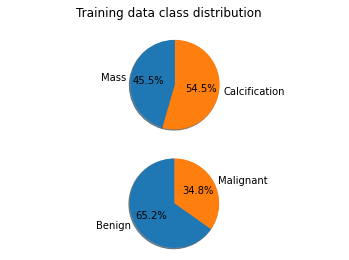

In [ ]:
import matplotlib.pyplot as plt

mass_size = (mc_collapsed_training_labels == 0).sum()
calcification_size = (mc_collapsed_training_labels == 1).sum()

benignant_size = (bm_collapsed_test_labels == 0).sum()
malignant_size = (bm_collapsed_test_labels == 1).sum()
(bm_collapsed_test_labels == 1).sum()
# Plot the distribution of the first dataset
labels = 'Mass', 'Calcification'
sizes = [mass_size, calcification_size]


fig, (ax1, ax2) = plt.subplots(2)

fig.suptitle('Training data class distribution')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 


# Plot the distribution of the second dataset
labels = 'Benign', 'Malignant'
sizes = [benignant_size, malignant_size]
ax2.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')

plt.show()



In [ ]:
#Early stop conditon 
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE)

In [ ]:
#shuffle data
def shuffle_data(data, labels):
  c = list(zip(data, labels))
  random.shuffle(c)
  t_data, t_labels = zip(*c)
  t_data = np.array(t_data)
  t_labels = np.array(t_labels)
  return t_data, t_labels

test_labels_without_baseline, test_labels_without_baseline  =  shuffle_data(test_labels_without_baseline, test_labels_without_baseline)

Showing the plots according to the training history of the model

In [ ]:
def show_plots(history):
  #plot the accurasy of the Training and Validation Set
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

Data Augmentation

In [ ]:
#data augmentation
def augmentation_generator_rescale(data, labels):  
  gen_train = ImageDataGenerator(
        rescale=1./RESCALE,
        rotation_range=360,
        horizontal_flip=True,
        vertical_flip=True,
        height_shift_range = 0.1, 
        width_shift_range = 0.1, 
        shear_range = 0.01,
        zoom_range=0.1,
        fill_mode='nearest')

  return gen_train.flow(data, labels, batch_size=BATCH_SIZE)

In [ ]:
#data augmentation
def augmentation_generator(data, labels):  
  gen_train = ImageDataGenerator(
        rotation_range=360,
        horizontal_flip=True,
        vertical_flip=True,
        height_shift_range = 0.1, 
        width_shift_range = 0.1, 
        shear_range = 0.01,
        zoom_range=0.1,
        fill_mode='nearest')

  return gen_train.flow(data, labels, batch_size=BATCH_SIZE)

###Model Declaration

Model 10035

In [ ]:
def get_model10035(learning_rate=0.0001):
  kernel_size = (3,3)
  pool_size= (2,2)
  first_filters = 32
  second_filters = 64
  third_filters = 128
  fourth_filters = 256

  model = models.Sequential()
  model.add(layers.Conv2D(first_filters, kernel_size, input_shape = (150, 150, 1)))
  model.add(layers.Conv2D(first_filters, kernel_size))
  model.add(layers.Conv2D(first_filters, kernel_size))
  model.add(layers.MaxPooling2D(pool_size = kernel_size)) 

  model.add(layers.Conv2D(second_filters, kernel_size))
  model.add(layers.Conv2D(second_filters, kernel_size))
  model.add(layers.MaxPooling2D(pool_size = pool_size))

  model.add(layers.Conv2D(third_filters, kernel_size))
  model.add(layers.Conv2D(third_filters, kernel_size))
  model.add(layers.MaxPooling2D(pool_size = pool_size))

  model.add(layers.Conv2D(fourth_filters, kernel_size))
  model.add(layers.MaxPooling2D(pool_size = pool_size))

  model.add(layers.Flatten())
  model.add(layers.Dense(2048, activation="relu"))
  model.add(layers.Dense(2048, activation="relu"))
  model.add(layers.Dense(2, activation="softmax"))

  ada = keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=ada, loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  model.summary()
  return model



Our created Model

In [ ]:
def get_regularized_model(learning_rate=0.0001):
  kernel_size = (3,3)
  pool_size= (2,2)
  first_filters = 32
  second_filters = 64
  third_filters = 128
  fourth_filters = 256

  dropout_conv = 0.3
  dropout_dense = 0.3
  
  reg = regularizers.l1_l2(l1=1e-5, l2=1e-4)
  #by adding the regularization, we maximum accuracy we reached is around 85%
  model = models.Sequential()
  model.add(layers.Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (150, 150, 1), kernel_regularizer=reg))
  model.add(layers.Conv2D(first_filters, kernel_size, activation = 'relu', kernel_regularizer=reg))
  model.add(layers.Conv2D(first_filters, kernel_size, activation = 'relu', kernel_regularizer=reg))
  model.add(layers.MaxPooling2D(pool_size = pool_size)) 
  model.add(layers.Dropout(dropout_conv))

  model.add(layers.Conv2D(second_filters, kernel_size, activation ='relu', kernel_regularizer=reg))
  model.add(layers.Conv2D(second_filters, kernel_size, activation ='relu', kernel_regularizer=reg))
  model.add(layers.Conv2D(second_filters, kernel_size, activation ='relu', kernel_regularizer=reg))
  model.add(layers.MaxPooling2D(pool_size = pool_size))
  model.add(layers.Dropout(dropout_conv))

  model.add(layers.Conv2D(third_filters, kernel_size, activation ='relu', kernel_regularizer=reg))
  model.add(layers.Conv2D(third_filters, kernel_size, activation ='relu', kernel_regularizer=reg))
  model.add(layers.Conv2D(third_filters, kernel_size, activation ='relu', kernel_regularizer=reg))
  model.add(layers.MaxPooling2D(pool_size = pool_size))
  model.add(layers.Dropout(dropout_conv))

  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation = "relu", kernel_regularizer=reg))
  model.add(layers.Dropout(dropout_dense))
  model.add(layers.Dense(512, activation = "relu", kernel_regularizer=reg))
  model.add(layers.Dropout(dropout_dense))
  model.add(layers.Dense(2, activation = "softmax"))

  ada = keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=ada, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
  model.summary()
  return model

##Training & Testing Mass vs Calcification

###Model 1.0.0.35

Training the a classifier over Mass Vs calcification training data

30% of train data is considered as Validation

70% of data is considered as Training

Epoch = 30


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 144, 144, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0

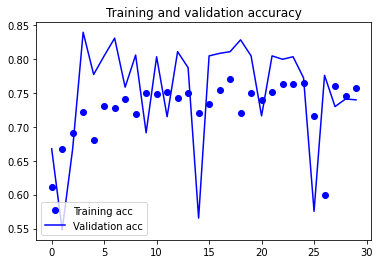

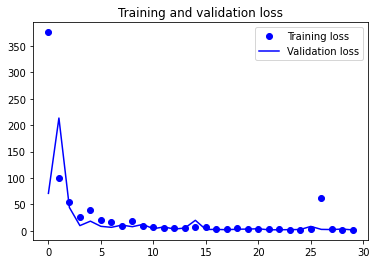

In [ ]:
# Split train dataset in train and validation
train_data, validation_data, train_labels, validation_labels = train_test_split(training_dataset_without_baseline,
                                                                                to_categorical(mc_collapsed_training_labels),
                                                                                train_size=0.7,
                                                                                random_state=42,
                                                                                shuffle=True)
gen_val = ImageDataGenerator(rescale=)
val_data = gen_val.flow(validation_data, validation_labels, batch_size=BATCH_SIZE)#generate validation data
t_data = augmentation_generator(train_data, train_labels)#generate augmented train data
model = get_model10035()
history = model.fit(t_data, epochs=EPOCH, steps_per_epoch=int(np.ceil(t_data.n / float(BATCH_SIZE))), 
                         validation_data=val_data, validation_steps=int(np.ceil(val_data.n / float(BATCH_SIZE))))
show_plots(history)

Test the trained model in the previous step

Mass Vs Calcification

In [ ]:
from sklearn.metrics import accuracy_score
test_gen = ImageDataGenerator()
test_data = test_gen.flow(test_dataset_without_baseline, to_categorical(mc_collapsed_test_labels), batch_size=BATCH_SIZE)
test_loss, test_accuracy = model.evaluate(test_data, steps=np.ceil(test_data.n/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

21/21 [==============================] - 0s 9ms/step - loss: 1.6617 - accuracy: 0.6726
Accuracy on test dataset: 0.6726190447807312


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 144, 144, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0

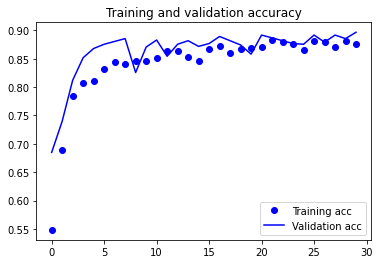

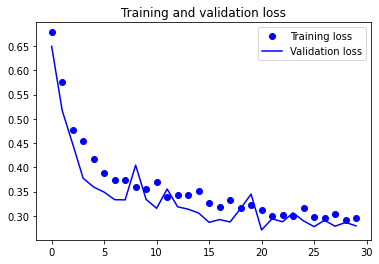

In [ ]:
# Split train dataset in train and validation
train_data, validation_data, train_labels, validation_labels = train_test_split(training_dataset_without_baseline,
                                                                                to_categorical(mc_collapsed_training_labels),
                                                                                train_size=0.7,
                                                                                random_state=42,
                                                                                shuffle=True)
gen_val = ImageDataGenerator(rescale=1./RESCALE)
val_data = gen_val.flow(validation_data, validation_labels, batch_size=BATCH_SIZE)#generate validation data
t_data = augmentation_generator_rescale(train_data, train_labels)#generate augmented train data
model = get_model10035()
history = model.fit(t_data, epochs=EPOCH, steps_per_epoch=int(np.ceil(t_data.n / float(BATCH_SIZE))), 
                         validation_data=val_data, validation_steps=int(np.ceil(val_data.n / float(BATCH_SIZE))))
show_plots(history)

In [ ]:
from sklearn.metrics import accuracy_score
test_gen = ImageDataGenerator(rescale=1./RESCALE)
test_data = test_gen.flow(test_dataset_without_baseline, to_categorical(mc_collapsed_test_labels), batch_size=BATCH_SIZE)
test_loss, test_accuracy = model.evaluate(test_data, steps=np.ceil(test_data.n/BATCH_SIZE))
res = np.argmax(model.predict(test_data), axis=-1)
print("predicted results:", accuracy_score(mc_collapsed_test_labels,res))
print('Accuracy on test dataset:', test_accuracy)

21/21 [==============================] - 0s 7ms/step - loss: 0.3316 - accuracy: 0.8571
predicted results: 0.49404761904761907
Accuracy on test dataset: 0.8571428656578064


Training the a classifier over Mass Vs Calcification training data

30% of train data is considered as Validation

70% of data is considered as Training

Epoch = 30

Class Weights

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 144, 144, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

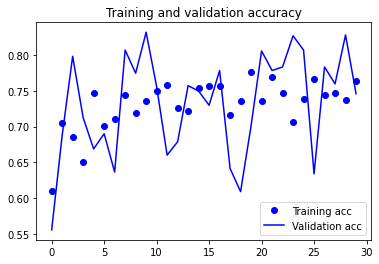

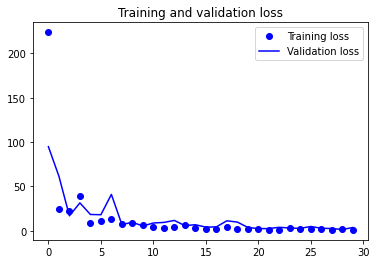

In [ ]:
EPOCH = 30
class_weights = {0:calcification_size/(mass_size+calcification_size), 1:mass_size/(mass_size+calcification_size)}
# Split train dataset in train and validation
train_data, validation_data, train_labels, validation_labels = train_test_split(training_dataset_without_baseline,
                                                                                to_categorical(mc_collapsed_training_labels),
                                                                                train_size=0.7,
                                                                                random_state=42,
                                                                                shuffle=True)
gen_val = ImageDataGenerator()
val_data = gen_val.flow(validation_data, validation_labels, batch_size=BATCH_SIZE)#generate validation data
t_data = augmentation_generator(train_data, train_labels)#generate augmented train data
scratch_cnn_mc_w_7030_40e = get_model10035()
history = scratch_cnn_mc_w_7030_40e.fit(t_data, class_weight=class_weights,epochs=EPOCH, steps_per_epoch=int(np.ceil(t_data.n / float(BATCH_SIZE))), 
                         validation_data=val_data, validation_steps=int(np.ceil(val_data.n / float(BATCH_SIZE))))
show_plots(history)

Test the trained model in the previous step

Mass Vs Calcification

In [ ]:
test_gen = ImageDataGenerator()
test_data = test_gen.flow(test_dataset_without_baseline, to_categorical(mc_collapsed_test_labels), batch_size=BATCH_SIZE)
test_loss, test_accuracy = scratch_cnn_mc_w_7030_40e.evaluate(test_data)
print('Accuracy on test dataset:', test_accuracy)

21/21 [==============================] - 0s 10ms/step - loss: 3.8721 - accuracy: 0.7202
Accuracy on test dataset: 0.7202380895614624


Save the model

In [ ]:
scratch_cnn_mc_w_7030_40e.save(os.path.join(MODEL_DIR,'MC/scratch_cnn_mc_w_7030_40e.h5'))
# tf.saved_model.save(scratch_cnn_mc_w_7030_40e, MODEL_DIR+'MC/scratch_cnn_mc_w_7030_40e')

Training the a classifier over Mass Vs Calcification training data

30% of train data is considered as Validation

70% of data is considered as Training

Early stop with 6 patience

Epoch = 80

Class Weights

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 144, 144, 32)      9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 22, 22, 64)       

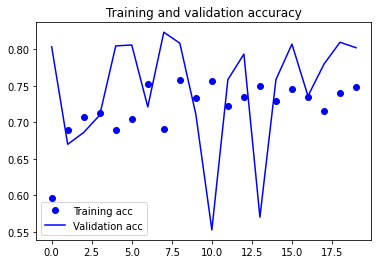

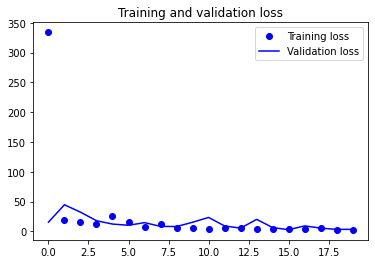

In [ ]:
EPOCH = 80
class_weights = {0:calcification_size/(mass_size+calcification_size), 1:mass_size/(mass_size+calcification_size)}
# Split train dataset in train and validation
train_data, validation_data, train_labels, validation_labels = train_test_split(training_dataset_without_baseline,
                                                                                to_categorical(mc_collapsed_training_labels),
                                                                                train_size=0.7,
                                                                                random_state=42,
                                                                                shuffle=True)
gen_val = ImageDataGenerator()
val_data = gen_val.flow(validation_data, validation_labels, batch_size=BATCH_SIZE)#generate validation data
t_data = augmentation_generator(train_data, train_labels)#generate augmented train data
scratch_cnn_mc_er_w_7030_40e = get_model10035()
history = scratch_cnn_mc_er_w_7030_40e.fit(t_data, callbacks=[early_stop], class_weight=class_weights,epochs=EPOCH, steps_per_epoch=int(np.ceil(t_data.n / float(BATCH_SIZE))), 
                         validation_data=val_data, validation_steps=int(np.ceil(val_data.n / float(BATCH_SIZE))))
show_plots(history)

Test the trained model in the previous step

Mass Vs Calcification

In [ ]:
test_gen = ImageDataGenerator()
test_data = test_gen.flow(test_dataset_without_baseline, to_categorical(mc_collapsed_test_labels), batch_size=BATCH_SIZE)
test_loss, test_accuracy = scratch_cnn_mc_er_w_7030_40e.evaluate(test_data)
print('Accuracy on test dataset:', test_accuracy)

21/21 [==============================] - 0s 9ms/step - loss: 4.1850 - accuracy: 0.7827
Accuracy on test dataset: 0.7827380895614624


Save the model

In [ ]:
scratch_cnn_mc_er_w_7030_40e.save(os.path.join(MODEL_DIR,'MC/scratch_cnn_mc_er_w_7030_40e.h5'))
# tf.saved_model.save(scratch_cnn_mc_er_w_7030_40e, MODEL_DIR+'MC/scratch_cnn_mc_er_w_7030_40e')

###Our Invented Model

Training the a classifier over Benignant Vs Malignant training data

30% of train data is considered as Validation

70% of data is considered as Training

Epoch = 30

Class Weights

Regularized Model with L1 and L2 regularization

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 144, 144, 32)      9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 22, 22, 64)       

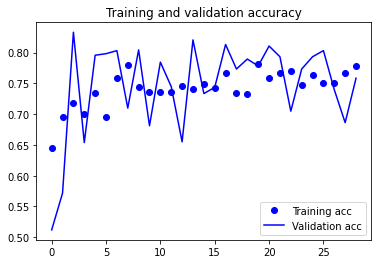

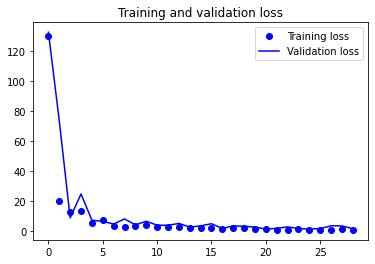

In [ ]:
EPOCH = 30
class_weights = {0:calcification_size/(mass_size+calcification_size), 1:mass_size/(mass_size+calcification_size)}
# Split train dataset in train and validation
train_data, validation_data, train_labels, validation_labels = train_test_split(training_dataset_without_baseline,
                                                                                to_categorical(mc_collapsed_training_labels),
                                                                                train_size=0.7,
                                                                                random_state=42,
                                                                                shuffle=True)
gen_val = ImageDataGenerator()
val_data = gen_val.flow(validation_data, validation_labels, batch_size=BATCH_SIZE)#generate validation data
t_data = augmentation_generator(train_data, train_labels)#generate augmented train data
scratch_cnn_mc_m2_w_7030_40e = get_model10035()
history = scratch_cnn_mc_m2_w_7030_40e.fit(t_data, class_weight=class_weights,epochs=EPOCH, steps_per_epoch=int(np.ceil(t_data.n / float(BATCH_SIZE))), 
                         validation_data=val_data, validation_steps=int(np.ceil(val_data.n / float(BATCH_SIZE))), callbacks=[early_stop])
show_plots(history)

Test the trained model in the previous step

Mass Vs Calcification

In [ ]:
test_gen = ImageDataGenerator()
test_data = test_gen.flow(test_dataset_without_baseline, to_categorical(mc_collapsed_test_labels), batch_size=BATCH_SIZE)
test_loss, test_accuracy = scratch_cnn_mc_m2_w_7030_40e.evaluate(test_data, steps=np.ceil(test_data.n/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

21/21 [==============================] - 0s 10ms/step - loss: 1.5005 - accuracy: 0.7530
Accuracy on test dataset: 0.7529761791229248


Save the model

In [ ]:
scratch_cnn_mc_m2_w_7030_40e.save(os.path.join(MODEL_DIR,'MC/scratch_cnn_mc_m2_w_7030_40e.h5'))
# tf.saved_model.save(scratch_cnn_mc_m2_w_7030_40e, MODEL_DIR+'MC/scratch_cnn_mc_m2_w_7030_40e')

###Cross Validation

10 fold cross validaiton
Mass Vs Calcification



In [ ]:
k = 10
EPOCH = 25
data, labels = shuffle_data(data=training_dataset_without_baseline, labels=mc_collapsed_training_labels) #shuffle data
num_val_samples = len(data) // k
validation_acc = []
validation_loss = []
validation_scores = []
for fold in range(k):
    # validation data: data from partition k
    val_data = data[fold * num_val_samples: (fold + 1) * num_val_samples]
    val_labels = labels[fold * num_val_samples: (fold + 1) * num_val_samples]
    gen_val = ImageDataGenerator()
    val_data = gen_val.flow(val_data, to_categorical(val_labels), batch_size=BATCH_SIZE)
    # training data: data from all other partitions
    t_data = np.concatenate([data[:fold * num_val_samples],  data[(fold+ 1) * num_val_samples:]], axis=0)
    t_labels = np.concatenate([labels[:fold * num_val_samples],  labels[(fold+ 1) * num_val_samples:]], axis=0)
    t_data = augmentation_generator(t_data, to_categorical(t_labels))
    # Build the Keras model
    model = get_model10035() # create a brand new instance of the model at each iteration
    model.fit(t_data, epochs=EPOCH, steps_per_epoch=int(np.ceil(t_data.n / float(BATCH_SIZE))))
    scores = model.evaluate(val_data,steps=int(np.ceil(val_data.n / float(BATCH_SIZE))))
    # Evaluate the model on the validation data
    validation_scores.append(scores) 
    # it is better to delete the model and clear session to free memory
    keras.backend.clear_session()

# validation score: average of the validation scores of the k folds

sum = 0
for l in validation_scores:
  sum+=l[1]
print("Validation Accuracy:", sum/k)

data, labels = shuffle_data(data=training_dataset_without_baseline, labels=mc_collapsed_training_labels) #shuffle data
t_data = augmentation_generator(data, to_categorical(labels))#generate augmented train data
model = get_model10035()
model.fit(t_data, epochs=EPOCH, steps_per_epoch=int(np.ceil(t_data.n / float(BATCH_SIZE))))
test_gen = ImageDataGenerator()
test_data = test_gen.flow(test_dataset_without_baseline, to_categorical(mc_collapsed_test_labels), batch_size=BATCH_SIZE)
predicted = model.predict(test_data, batch_size=BATCH_SIZE)
predicted = np.argmax(predicted, axis=-1)
test_loss, test_accuracy = model.evaluate(test_data, steps=np.ceil(test_data.n/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 144, 144, 32)      9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 22, 22, 64)       

Save the Mass Vs Calcification Model



In [ ]:
model.save(os.path.join(MODEL_DIR,'MC/scratch_cnn_mc_cv.h5'))
# tf.saved_model.save(model, MODEL_DIR+'MC/scratch_cnn_mc_cv')

Test the Mass Vs Calcification




In [ ]:
test_gen = ImageDataGenerator()
test_data = test_gen.flow(test_dataset_without_baseline, to_categorical(mc_collapsed_test_labels), batch_size=BATCH_SIZE)
test_loss, test_accuracy = model.evaluate(test_data, steps=np.ceil(test_data.n/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

21/21 [==============================] - 0s 12ms/step - loss: 1.2543 - accuracy: 0.8036
Accuracy on test dataset: 0.8035714030265808


##Training & Testing Benignant vs Malignant

Training the a classifier over Benignant Vs Malignant training data

30% of train data is considered as Validation

70% of data is considered as Training

Epoch = 30

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 144, 144, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

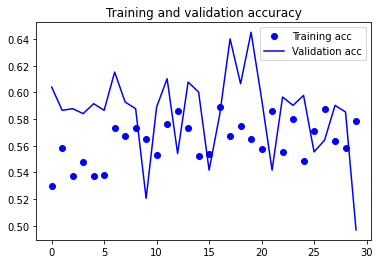

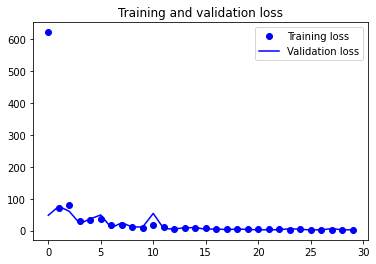

In [ ]:
EPOCH = 30
train_data, validation_data, train_labels, validation_labels = train_test_split(training_dataset_without_baseline,
                                                                                to_categorical(bm_collapsed_training_labels),
                                                                                train_size=0.7,
                                                                                random_state=42,
                                                                                shuffle=True)

gen_val = ImageDataGenerator()
val_data = gen_val.flow(validation_data, validation_labels, batch_size=BATCH_SIZE)#generate validation data
t_data = augmentation_generator(train_data, train_labels)#generate augmented train data
model = get_model10035()
history = model.fit(t_data, epochs=EPOCH, steps_per_epoch=int(np.ceil(t_data.n / float(BATCH_SIZE))), 
                         validation_data=val_data, validation_steps=int(np.ceil(val_data.n / float(BATCH_SIZE))))
show_plots(history)

Test the trained model in the previous step

Benignant Vs Malignant

In [ ]:
test_gen = ImageDataGenerator()
test_data = test_gen.flow(test_dataset_without_baseline, to_categorical(bm_collapsed_test_labels), batch_size=BATCH_SIZE)
test_loss, test_accuracy = model.evaluate(test_data)
print('Accuracy on test dataset:', test_accuracy)

21/21 [==============================] - 0s 10ms/step - loss: 2.4411 - accuracy: 0.4345
Accuracy on test dataset: 0.4345238208770752


Training the a classifier over Benignant Vs Malignant training data

30% of train data is considered as Validation

70% of data is considered as Training

Epoch = 30

Class Weights

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 144, 144, 32)      9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 22, 22, 64)       

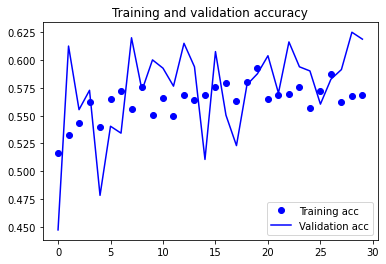

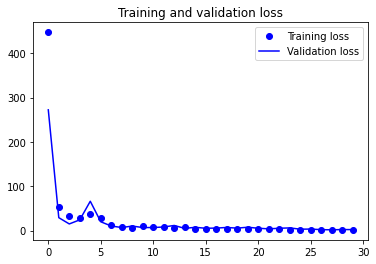

In [ ]:
class_weights = {0:benignant_size/(benignant_size+malignant_size), 1:benignant_size/(benignant_size+malignant_size)}
train_data, validation_data, train_labels, validation_labels = train_test_split(training_dataset_without_baseline,
                                                                                to_categorical(bm_collapsed_training_labels),
                                                                                train_size=0.7,
                                                                                random_state=42,
                                                                                shuffle=True)

gen_val = ImageDataGenerator()
val_data = gen_val.flow(validation_data, validation_labels, batch_size=BATCH_SIZE)#generate validation data
t_data = augmentation_generator(train_data, train_labels)#generate augmented train data
scratch_cnn_bm_w_7030_40e = get_model10035()
history = scratch_cnn_bm_w_7030_40e.fit(t_data, class_weight=class_weights, epochs=EPOCH, steps_per_epoch=int(np.ceil(t_data.n / float(BATCH_SIZE))), 
                         validation_data=val_data, validation_steps=int(np.ceil(val_data.n / float(BATCH_SIZE))))
show_plots(history)

Test the trained model in the previous step

Benignant Vs Malignant

In [ ]:
test_gen = ImageDataGenerator()
test_data = test_gen.flow(test_dataset_without_baseline, to_categorical(bm_collapsed_test_labels), batch_size=BATCH_SIZE)
test_loss, test_accuracy = scratch_cnn_bm_w_7030_40e.evaluate(test_data, steps=np.ceil(test_data.n/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

21/21 [==============================] - 0s 10ms/step - loss: 1.8422 - accuracy: 0.6429
Accuracy on test dataset: 0.6428571343421936


Save the Model

In [ ]:
scratch_cnn_bm_w_7030_40e.save(os.path.join(MODEL_DIR,'BM/scratch_cnn_bm_w_7030_40e.h5'))
# tf.saved_model.save(scratch_cnn_bm_w_7030_40e, MODEL_DIR+'BM/scratch_cnn_bm_w_7030_40e')

Training the a classifier over Benignant Vs Malignant training data

30% of train data is considered as Validation

70% of data is considered as Training

Early stop with 6 patience

Epoch = 80

Class Weights

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 144, 144, 32)      9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 22, 22, 64)       

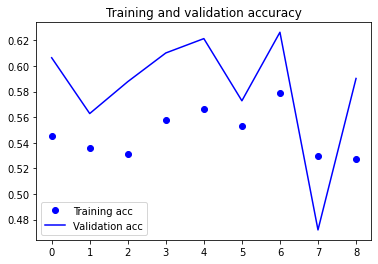

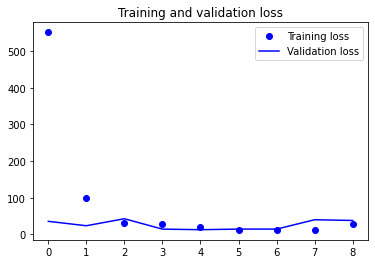

In [ ]:
EPOCH = 80
class_weights = {0:benignant_size/(benignant_size+malignant_size), 1:benignant_size/(benignant_size+malignant_size)}
train_data, validation_data, train_labels, validation_labels = train_test_split(training_dataset_without_baseline,
                                                                                to_categorical(bm_collapsed_training_labels),
                                                                                train_size=0.7,
                                                                                random_state=42,
                                                                                shuffle=True)

gen_val = ImageDataGenerator()
val_data = gen_val.flow(validation_data, validation_labels, batch_size=BATCH_SIZE)#generate validation data
t_data = augmentation_generator(train_data, train_labels)#generate augmented train data
scratch_cnn_bm_er_w_7030_40e = get_model10035()
history = scratch_cnn_bm_er_w_7030_40e.fit(t_data, callbacks=[early_stop], class_weight=class_weights, epochs=EPOCH, steps_per_epoch=int(np.ceil(t_data.n / float(BATCH_SIZE))), 
                         validation_data=val_data, validation_steps=int(np.ceil(val_data.n / float(BATCH_SIZE))))
show_plots(history)

Test the trained model in the previous step

Benignant Vs Malignant

In [ ]:
test_gen = ImageDataGenerator()
test_data = test_gen.flow(test_dataset_without_baseline, to_categorical(bm_collapsed_test_labels), batch_size=BATCH_SIZE)
test_loss, test_accuracy = scratch_cnn_bm_er_w_7030_40e.evaluate(test_data, steps=np.ceil(test_data.n/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

21/21 [==============================] - 0s 9ms/step - loss: 31.0569 - accuracy: 0.6518
Accuracy on test dataset: 0.6517857313156128


Save the model

In [ ]:
scratch_cnn_bm_er_w_7030_40e.save(os.path.join(MODEL_DIR,'BM/scratch_cnn_bm_er_w_7030_40e.h5'))
# tf.saved_model.save(scratch_cnn_bm_er_w_7030_40e, MODEL_DIR+'BM/scratch_cnn_bm_er_w_7030_40e')

###Our Invented Model

Training the a classifier over Benignant Vs Malignant training data

30% of train data is considered as Validation

70% of data is considered as Training

Epoch = 30

Class Weights

Regularized Model with L1 and L2 regularization

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 144, 144, 32)      9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 72, 72, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 70, 70, 64)        18496     
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 68, 68, 64)       

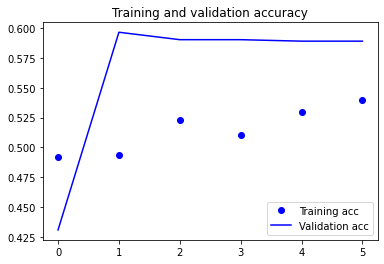

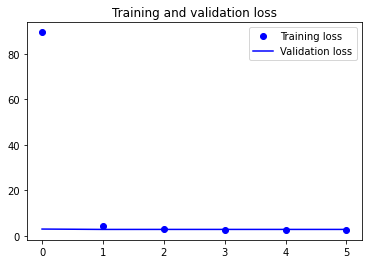

In [ ]:
class_weights = {0:benignant_size/(benignant_size+malignant_size), 1:benignant_size/(benignant_size+malignant_size)}
train_data, validation_data, train_labels, validation_labels = train_test_split(training_dataset_without_baseline,
                                                                                to_categorical(bm_collapsed_training_labels),
                                                                                train_size=0.7,
                                                                                random_state=42,
                                                                                shuffle=True)

gen_val = ImageDataGenerator()
val_data = gen_val.flow(validation_data, validation_labels, batch_size=BATCH_SIZE)#generate validation data
t_data = augmentation_generator(train_data, train_labels)#generate augmented train data
scratch_cnn_bm_m2_w_7030_40e = get_regularized_model()
history = scratch_cnn_bm_m2_w_7030_40e.fit(t_data, class_weight=class_weights, epochs=EPOCH, steps_per_epoch=int(np.ceil(t_data.n / float(BATCH_SIZE))), 
                         validation_data=val_data, validation_steps=int(np.ceil(val_data.n / float(BATCH_SIZE))), callbacks=[early_stop])
show_plots(history)

Test the trained model in the previous step

Benignant Vs Malignant

In [ ]:
test_gen = ImageDataGenerator()
test_data = test_gen.flow(test_dataset_without_baseline, to_categorical(bm_collapsed_test_labels), batch_size=BATCH_SIZE)
test_loss, test_accuracy = scratch_cnn_bm_m2_w_7030_40e.evaluate(test_data, steps=np.ceil(test_data.n/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

21/21 [==============================] - 0s 14ms/step - loss: 2.8937 - accuracy: 0.6518
Accuracy on test dataset: 0.6517857313156128


Save the model

In [ ]:
scratch_cnn_bm_m2_w_7030_40e.save(os.path.join(MODEL_DIR,'BM/scratch_cnn_bm_m2_w_7030_40e.h5'))
# tf.saved_model.save(scratch_cnn_bm_m2_w_7030_40e, MODEL_DIR+'BM/scratch_cnn_bm_m2_w_7030_40e')

###Cross Validation

10 fold cross validaiton
Benignant Vs Malignant



In [ ]:
k = 10
EPOCH = 25
data, labels = shuffle_data(data=training_dataset_without_baseline, labels=bm_collapsed_training_labels) #shuffle data
num_val_samples = len(data) // k
validation_acc = []
validation_loss = []
validation_scores = []
for fold in range(k):
    # validation data: data from partition k
    val_data = data[fold * num_val_samples: (fold + 1) * num_val_samples]
    val_labels = labels[fold * num_val_samples: (fold + 1) * num_val_samples]
    gen_val = ImageDataGenerator()
    val_data = gen_val.flow(val_data, to_categorical(val_labels), batch_size=BATCH_SIZE)
    # training data: data from all other partitions
    t_data = np.concatenate([data[:fold * num_val_samples],  data[(fold+ 1) * num_val_samples:]], axis=0)
    t_labels = np.concatenate([labels[:fold * num_val_samples],  labels[(fold+ 1) * num_val_samples:]], axis=0)
    t_data = augmentation_generator(t_data, to_categorical(t_labels))
    # Build the Keras model
    model = get_model10035() # create a brand new instance of the model at each iteration
    model.fit(t_data, epochs=EPOCH, steps_per_epoch=int(np.ceil(t_data.n / float(BATCH_SIZE))))
    scores = model.evaluate(val_data,steps=int(np.ceil(val_data.n / float(BATCH_SIZE))))
    # Evaluate the model on the validation data
    validation_scores.append(scores) 
    # it is better to delete the model and clear session to free memory
    keras.backend.clear_session()

# validation score: average of the validation scores of the k folds

sum = 0
for l in validation_scores:
  sum+=l[1]
print("Validation Accuracy:", sum/k)

data, labels = shuffle_data(data=training_dataset_without_baseline, labels=bm_collapsed_training_labels) #shuffle data
t_data = augmentation_generator(data, to_categorical(labels))#generate augmented train data
model = get_model10035()
model.fit(t_data, epochs=EPOCH, steps_per_epoch=int(np.ceil(t_data.n / float(BATCH_SIZE))))
test_gen = ImageDataGenerator()
test_data = test_gen.flow(test_dataset_without_baseline, to_categorical(bm_collapsed_test_labels), batch_size=BATCH_SIZE)
test_loss, test_accuracy = model.evaluate(test_data, steps=np.ceil(test_data.n/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 144, 144, 32)      9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 22, 22, 64)       

Save Benignant Vs Malignant Model

In [ ]:
model.save(os.path.join(MODEL_DIR,'BM/scratch_cnn_bm_cv.h5'))
# tf.saved_model.save(model, MODEL_DIR+'BM/scratch_cnn_bm_cv')

Predict the Benignant Vs Malignant

In [ ]:
test_gen = ImageDataGenerator()
test_data = test_gen.flow(test_dataset_without_baseline, to_categorical(bm_collapsed_test_labels), batch_size=BATCH_SIZE)
predicted = model.predict(test_data, batch_size=BATCH_SIZE)
predicted = np.argmax(predicted, axis=-1)
test_loss, test_accuracy = model.evaluate(test_data, steps=np.ceil(test_data.n/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

21/21 [==============================] - 0s 10ms/step - loss: 1.7295 - accuracy: 0.6518
Accuracy on test dataset: 0.6517857313156128
